# GRPO Training project: teach an LLM to do additions, again

In this notebook, you'll find:
* A basic Transformer with basic tokenizer
* A basic dataset for additions
* A classical pre-trainer, minimizing cross entropy loss
* A Vanilla GRPO

You're not supposed to edit the existing code (you can if you want to...).
You should implement one (or more) of the following:
* GRPO with PPO (the `usual` one)
* RLOO
* ReMax
* DPO
* RAFT
* your own RLHF method!

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

import random
import math
import re
import time
import copy

In [2]:
num_digits = 3

dataset_size = 64_000
train_proportion = 0.9

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Step 1: Construct a tokenizer

In [4]:
pad_token="[PAD]"
eos_token="[EOS]"

class character_level_tokenizer:
    """
    character-level
    """
    def __init__(self):
        self.vocab = [str(x) for x in range(10)] + ["+", "="] + [pad_token, eos_token]
        self.token_to_id = {v : k for k, v in enumerate(self.vocab)}
        self.id_to_token = {k : v for k, v in enumerate(self.vocab)}
        self.ntokens = len(self.vocab)
        self.pattern = f"[^{re.escape(''.join(self.vocab))}]"

    def clean(self, text):
        """
        removes all characters not in the vocabulary
        """
        out = re.sub(self.pattern, "", text)
        return out

    def pre_tokenization(self, text):
        """
        character-level
        """
        return [c for c in text]

    def encode(self, text):
        text_list = self.pre_tokenization(self.clean(text))
        return [self.token_to_id[c] for c in text_list]

    def decode(self, token_list):
        return "".join([self.id_to_token[x] for x in token_list])
    
tokenizer = character_level_tokenizer()
ntokens = tokenizer.ntokens
ntokens

14

In [5]:
prompt = "12 + 42 ="
inputs = tokenizer.encode(prompt)
inputs, tokenizer.decode(inputs)

([1, 2, 10, 4, 2, 11], '12+42=')

## Step 2: Create a dataset for arithmetic operations

In [6]:
def sample_datapoint(num_digits = 3):
    a_list = [random.randint(0, 9) for _ in range(num_digits)]
    b_list = [random.randint(0, 9) for _ in range(num_digits)]
    a_int = int("".join([str(x) for x in a_list]))
    b_int = int("".join([str(x) for x in b_list]))
    a_str = "".join([str(x) for x in a_list])
    b_str = "".join([str(x) for x in b_list])
    sum_int = a_int + b_int
    return (a_str + "+" + b_str + "=", str(sum_int))

sample_datapoint(3)

('399+425=', '824')

In [7]:
data = []
for _ in range(dataset_size):
    data.append(sample_datapoint(num_digits))
data[:4]

[('487+575=', '1062'),
 ('276+106=', '382'),
 ('189+310=', '499'),
 ('368+547=', '915')]

In [8]:
data_train = data[: int(train_proportion * dataset_size)]
data_test = data[int(train_proportion * dataset_size):]

len(data_train),len(data_test)

(57600, 6400)

## Step 3: Construct a model

In [9]:
class PositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens in the sequence.
        The positional encodings have the same dimension as the embeddings, so that the two can be summed.
        Here, we use sine and cosine functions of different frequencies.
    .. math:
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        """

        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [10]:
class TransformerModel(nn.Transformer):
    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__(d_model=ninp,
                                               nhead=nhead,
                                               dim_feedforward=nhid,
                                               num_encoder_layers=nlayers)
        self.input_emb = nn.Embedding(ntoken, ninp)
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        self.decoder = nn.Linear(ninp, ntoken) # projection sur le vocabulaire

        self.ninp = ninp
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.input_emb.weight, -initrange, initrange)
        nn.init.zeros_(self.decoder.bias)
        nn.init.uniform_(self.decoder.weight, -initrange, initrange)

    def _generate_square_subsequent_mask(self, sz):
        return torch.log(torch.tril(torch.ones(sz,sz))) # masque de l'attention

    def forward(self, src):
        # S = sequence lenght = len(src), B = batch size, E = embedding dimension = ninp, V = vocab size = ntoken
        # src: (S, B)
        mask = self._generate_square_subsequent_mask(len(src)).to(device)
        self.src_mask = mask # (S, S)

        src = self.input_emb(src) * math.sqrt(self.ninp) # (S, B, E)
        src = self.pos_encoder(src)  # (S, B, E)
        output_enc = self.encoder(src, mask=self.src_mask) # (S, B, E) couches MultiHeadSelfAttention() pytorch
        output_dec = self.decoder(output_enc) # (S, B, V)
        return F.log_softmax(output_dec, dim=-1), output_enc # (S, B, V)

In [11]:
model = TransformerModel(ntoken = ntokens,
                         ninp = 128,
                         nhead = 16,
                         nhid = 64,
                         nlayers = 8)
model.to(device)

c:\Users\soelm\Documents\04_Code\MVA\MVA_venv\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


TransformerModel(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=64, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): Linear(in_features=128, out_features=14, bias=True)
  (input_emb): Embedding(14, 128)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [12]:
print("number of parameters: {}".format(sum([x.numel() for x in model.parameters()])))

number of parameters: 668942


### Useful functions

In [13]:
def generate(model, prompts, new_tokens = 5, mode = "greedy", num_samples = 1, temperature = 0.8):
    input_tensor = torch.repeat_interleave(prompts, repeats = num_samples, dim = 1).to(device) # (S, B*G) G= num generations per prompt
    # (prompt_length, batch_size * num_samples)
    for _ in range(new_tokens):
        output, _ = model(input_tensor) # (prompt_length, batch_size * num_samples, ntokens)
        logits = output[-1,:,:] # dernier token (batch_size * num_samples, ntokens)
        if mode == "greedy":
            tokens = torch.argmax(logits, -1).view((1,-1)) # (1, batch_size * num_samples)
        else: # mode == "sampling"
            logits /= temperature
            probs = torch.softmax(logits, dim=-1)
            tokens = torch.multinomial(probs, num_samples = 1).view((1,-1)) # (1, batch_size * num_samples)
        input_tensor = torch.cat((input_tensor, tokens), 0)
    return input_tensor

In [14]:
model.eval()

prompt = "2+3="
prompt_tensor = torch.tensor(tokenizer.encode(prompt)).view((-1,1))
output = generate(model, prompt_tensor).view((1,-1))
output, tokenizer.decode(output[0].tolist())

(tensor([[ 2, 10,  3, 11, 13, 13, 13, 13, 13]]),
 '2+3=[EOS][EOS][EOS][EOS][EOS]')

In [15]:
tokenizer.token_to_id

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 '+': 10,
 '=': 11,
 '[PAD]': 12,
 '[EOS]': 13}

In [16]:
def pad(token_list, type_list = "prompts"):
    max_length = max([len(x) for x in token_list]) # taille commune des sequences
    out = []
    for x in token_list:
        if type_list == "prompts":
            out.append([tokenizer.token_to_id[pad_token]] * (max_length - len(x)) + x) # padding à gauche
        if type_list == "answers":
            out.append(x + [tokenizer.token_to_id[eos_token]] + [tokenizer.token_to_id[pad_token]] * (max_length - len(x))) # padding à droite
    return out, max_length

In [17]:
prompts = [tokenizer.encode("1+1="), tokenizer.encode("21+35=")]
answers = [tokenizer.encode("2"), tokenizer.encode("56")]
padded_prompts, _ = pad(prompts, "prompts")
padded_answers, _ = pad(answers, "answers")
padded_prompts, padded_answers
[tokenizer.decode(p) for p in padded_prompts], [tokenizer.decode(p) for p in padded_answers]

(['[PAD][PAD]1+1=', '21+35='], ['2[EOS][PAD]', '56[EOS]'])

In [18]:
def get_batch(split, i, batch_size):
    data = data_train if split == 'train' else data_test

    prompts = [data[i][0] for i in range(i, i + batch_size)]
    encoded_prompts = [tokenizer.encode(prompt) for prompt in prompts]
    padded_prompts, prompt_length = pad(encoded_prompts, "prompts")

    answers = [data[i][1] for i in range(i, i + batch_size)]
    encoded_answers = [tokenizer.encode(answer) for answer in answers]
    padded_answers, answers_length = pad(encoded_answers, "answers")

    X = torch.stack([torch.tensor(x) for x in padded_prompts], 1)
    Y = torch.stack([torch.tensor(x) for x in padded_answers], 1)
    return X, Y, prompt_length, answers_length, prompts, answers

In [19]:
X, Y, prompt_length, answers_length, prompts, answers = get_batch("train", 43, 16)
X.shape, Y.shape, prompt_length, answers_length, prompts[0], answers[0]

(torch.Size([8, 16]), torch.Size([5, 16]), 8, 4, '491+750=', '1241')

## Step 4: Evaluate

In [20]:
batch_size = 16

In [21]:
def evaluate(batch_size = batch_size):
    # Turn on evaluation mode disables dropout.
    model.eval()
    correct = 0.
    with torch.no_grad():
        for batch, i in enumerate(range(0, len(data_test) - 1, batch_size)):
            prompts, target_answers, prompt_length, answers_length, _, _ = get_batch("test", i, batch_size)
            prompts = prompts.to(device) # (prompt_length, batch_size) (P, B)
            target_answers = target_answers.to(device) # (answers_length + 1, batch_size) (A, B)
            output = generate(model, prompts, answers_length + 1) # (prompt_length + answers_length + 1, batch_size) (P+A, B)
            answers_tokens = output[prompt_length:, :] # (answers_length + 1, batch_size), contains tokens (A, B)
            equality_test = answers_tokens == target_answers # (answers_length + 1, batch_size), contains boolean values
            correct += torch.all(equality_test, axis=0).float().sum()
        accuracy = correct / len(data_test)
    return accuracy.item()

In [22]:
evaluate()

0.0

## Step 5: Train the model, classical approach

### Hyperparameters

In [23]:
epochs = 5
batch_size = 16
learning_rate = 8e-4

reporting_per_epoch = 5
log_interval = len(data_train) // (reporting_per_epoch + 1)
assert(log_interval % batch_size == 0)

In [24]:
def train():
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    best_test_accuracy = None
    test_accuracy = evaluate()
    print('-' * 89)
    print('| initialisation | test accuracy {:5.2f}'.format(test_accuracy))
    print('-' * 89)
    for epoch in range(1, epochs+1):
        epoch_start_time = time.time()
        total_loss = 0.
        start_time = time.time()
        for batch, i in enumerate(range(0, len(data_train) - 1, batch_size)):
            prompts, target_answers, prompt_length, answers_length, _, _ = get_batch("train", i, batch_size)
            prompts = prompts.to(device) # (prompt_length, batch_size) (P, B)
            target_answers = target_answers.to(device) # (answers_length + 1, batch_size) (A, B)
            input_tensor = torch.cat((prompts, target_answers), 0) # (prompt_length + answers_length + 1, batch_size) (P+A, B)
            model.zero_grad()
            output, _ = model(input_tensor) # (prompt_length + answers_length + 1, batch_size, ntokens) # (P+A, B, V) probabilité sur le vocabulaire pour chaque token
            output_answers = output[prompt_length-1:-1,:,:].reshape(-1, ntokens) # ((answers_length + 1) * batch_size, ntokens) # (A*B, V) prob sur le vocab de la réponse
            target_answers = target_answers.view(-1) # (A*B)
            loss = F.cross_entropy(output_answers, target_answers)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if i % log_interval == 0 and batch > 0:
                cur_loss = total_loss / log_interval
                elapsed = time.time() - start_time
                print('| {:5d}/{:5d} batches | ms/batch {:5.2f} | loss {:5.2f} | perplexity {:8.2f}'.format(batch, len(data_train) // batch_size,
                                                                                                            elapsed * 1000 / log_interval, cur_loss, math.exp(cur_loss)))
                total_loss = 0
                start_time = time.time()
        test_accuracy = evaluate()
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | test accuracy {:5.2f}'.format(epoch, (time.time() - epoch_start_time), test_accuracy))
        print('-' * 89)
        # Save the model if the test accuracy is the best we've seen so far.
        if not best_test_accuracy or test_accuracy < best_test_accuracy:
            with open("arithmetic.pt", 'wb') as f:
                torch.save(model, f)
            best_test_accuracy = test_accuracy

In [25]:
train()

-----------------------------------------------------------------------------------------
| initialisation | test accuracy  0.00
-----------------------------------------------------------------------------------------
|   600/ 3600 batches | ms/batch  2.41 | loss  0.09 | perplexity     1.09
|  1200/ 3600 batches | ms/batch  2.40 | loss  0.07 | perplexity     1.07
|  1800/ 3600 batches | ms/batch  2.40 | loss  0.07 | perplexity     1.07
|  2400/ 3600 batches | ms/batch  2.41 | loss  0.07 | perplexity     1.07
|  3000/ 3600 batches | ms/batch  2.41 | loss  0.07 | perplexity     1.07
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 154.66s | test accuracy  0.01
-----------------------------------------------------------------------------------------
|   600/ 3600 batches | ms/batch  2.45 | loss  0.06 | perplexity     1.07
|  1200/ 3600 batches | ms/batch  2.39 | loss  0.06 | perplexity     1.06
|  1800/ 3600 batches | ms

In [26]:
model.eval()

for i in range(20):
    prompt, answers = data_test[i]
    prompt_tensor = torch.tensor(tokenizer.encode(prompt)).view((-1,1))
    output = generate(model, prompt_tensor, len(answers) + 1).view((1,-1))
    print(tokenizer.decode(output.tolist()[0]) + "\t actual result: " + answers)

103+569=673[EOS]	 actual result: 672
936+720=171[EOS][EOS]	 actual result: 1656
236+737=973[EOS]	 actual result: 973
273+702=975[EOS]	 actual result: 975
427+818=1235[EOS]	 actual result: 1245
712+297=910[EOS][PAD]	 actual result: 1009
882+786=1700[EOS]	 actual result: 1668
293+935=1221[EOS]	 actual result: 1228
085+664=740[EOS]	 actual result: 749
280+634=91[EOS][PAD]	 actual result: 914
327+455=782[EOS]	 actual result: 782
394+426=812[EOS]	 actual result: 820
163+969=1132[EOS]	 actual result: 1132
226+418=644[EOS]	 actual result: 644
501+680=1181[EOS]	 actual result: 1181
600+206=801[EOS]	 actual result: 806
419+797=1216[EOS]	 actual result: 1216
124+965=1099[EOS]	 actual result: 1089
227+422=649[EOS]	 actual result: 649
302+153=456[EOS]	 actual result: 455


## Step 4 bis: Coding DeepSeek GRPO

### Custom reward functions

In [27]:
def accuracy_reward(output, answer):
    # 1 si output=answer
    pattern = r"\[EOS\]"
    output = re.sub(pattern, "", output)
    pattern = r"(\[PAD\])*$"
    output = re.sub(pattern, "", output)
    return 1. if output == answer else 0.

accuracy_reward("123[EOS][PAD][PAD]", "123"), accuracy_reward("123", "124"),

(1.0, 0.0)

In [28]:
def distance_accuracy_reward(output, answer):
    # ecart relatif entre output et answer
    pattern = r"\[EOS\]"
    output = re.sub(pattern, "", output)
    pattern = r"(\[PAD\])*$"
    output = re.sub(pattern, "", output)
    int_output = int(output)
    int_answer = int(answer)
    return abs(int_output - int_answer) / max(int_output, int_answer)

distance_accuracy_reward("123[EOS]", "123"), distance_accuracy_reward("123[PAD]", "124"),

(0.0, 0.008064516129032258)

In [29]:
def digit_accuracy_reward(output, answer):
    # ecart relatif entre les digits
    pattern = r"\[EOS\]"
    output = re.sub(pattern, "", output)
    pattern = r"(\[PAD\])*$"
    output = re.sub(pattern, "", output)
    return sum(c1 == c2 for (c1,c2) in zip(output, answer)) / max(len(output), len(answer))

digit_accuracy_reward("123[EOS][PAD][PAD]", "123"), digit_accuracy_reward("123[EOS]", "123"),

(1.0, 1.0)

In [30]:
def reward_format(output):
    # 1 si format avec EOS
    pattern = r"\d+\[EOS\](\[PAD\])*$"
    return 1. if bool(re.match(pattern, output)) else 0.

reward_format("123[EOS][PAD][PAD]"), reward_format("123[EOS]"), reward_format("123"),

(1.0, 1.0, 0.0)

### Hyperparameters

In [31]:
epochs = 20
batch_size = 16 # B
learning_rate = 1e-4
num_samples = 16 # G
temperature = .8

reporting_per_epoch = 5
log_interval = len(data_train) // (reporting_per_epoch + 1)
assert(log_interval % batch_size == 0)

reward_fun = digit_accuracy_reward
reward_format = reward_format

In [32]:
def compute_rewards(text_outputs, answers):
    # reward pondérée
    repeated_answers = [answer for answer in answers for _ in range(num_samples)]
    rewards = torch.tensor(
        [0.2 * reward_format(output) + 0.8 * reward_fun(output, answer)
         for output, answer in zip(text_outputs, repeated_answers)],
        dtype=torch.float32,
        device=device
    )
    return rewards # (B*G)

### Coding our actual GRPO trainer


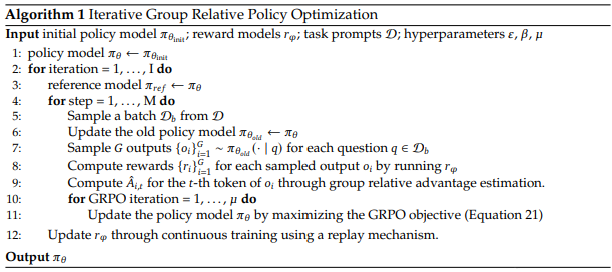

In [1]:
import base64
from IPython.display import HTML

def embed_image(filename):
    with open(filename, "rb") as f:
        data = base64.b64encode(f.read()).decode("utf-8")
    return HTML(f'<img src="data:image/png;base64,{data}" width="400px">')

embed_image("GRPO.png")


In [ ]:
class GRPOTrainer:
    """
    Entraîne un modèle en utilisant la méthode GRPO introduite dans l'article : DeepSeekMath: Pushing the Limits of Mathematical Reasoning in Open Language Models
    """
    def __init__(self, model, 
                 ref_model=None, 
                 learning_rate=1e-3, 
                 epochs = 3,
                 batch_size = 16,
                 num_samples = 5,
                 temperature = 0.8,
                 num_iterations = 2,
                 eps=0.2,
                 beta=0.4):
        """ 
        Initialise les hyper-paramètres d'entraînement.
        """
        self.model = model
        self.ref_model = ref_model
        self.learning_rate = learning_rate
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.learning_rate)
        self.epochs = epochs
        self.batch_size = batch_size # B
        self.num_samples = num_samples # G
        self.temperature = temperature
        self.num_iterations = num_iterations
        self.eps = eps # clipping parameter
        self.beta = beta# KL parameter

    def config(self):
        print("-"*89)
        print("| training hyper-parameters ")
        print("-"*89)
        print(f"num_epochs: {self.epochs}, batch_size: {self.batch_size}, batch_per_epochs: {(len(data_train) - 1)//self.batch_size}")
        print(f"num_samples: {self.num_samples}, num_iterations: {self.num_iterations}")
        print(f"eps: {self.eps}, beta: {self.beta}")
        print("-"*89)

    def _calculate_grpo_advantages(self, rewards):
        """ 
        Calcule les avantages de chaque réponse générée grâce à leur rewards.
        Args:
            rewards: rewards pré-calculées(B*G) 
        Returns: 
            advantages (B*G)
        """
        mean_rewards = rewards.view(-1, self.num_samples).mean(dim=1) # (B,)
        std_rewards = rewards.view(-1, self.num_samples).std(dim=1) # (B,)
        mean_rewards = mean_rewards.repeat_interleave(self.num_samples, dim=0) # (B*G,)
        std_rewards = std_rewards.repeat_interleave(self.num_samples, dim=0) # (B*G,)
        advantages = (rewards - mean_rewards) / (std_rewards + 1e-5) # (B*G,)
        return advantages
    
    def _compute_log_probs(self, model, outputs, prompt_length):
        """ 
        Calcule les log-probabilités (sur tout le vocabulaire) des tokens des réponses.
        Args:
            model: modèle à utiliser pour le calcul des probabilités des tokens
            outputs: (P+A, B*G) séquence générée
            promt_length: int longeur paddée des prompts du batch
        """
        log_probs, _ = model(outputs) #(P+A, B*G, V)
        log_probs = log_probs[prompt_length-1:-1, :, :] #(A, B*G, V)

        # log_softmax est déjà présent dans forward() donc pas besoin de l'appliquer à nouveau
        #log_probs = F.log_softmax(logits, dim=-1) #(A, B*G, V) convert raw logits into log probabilities along the vocabulary axis
        return log_probs #(A, B*G, V)

    def _compute_loss_deepseek(self, advantages, responses, answers_length, log_probs, log_probs_old, log_probs_ref):
        """ 
        Calcule la loss GRPO (DeepSeek) d'un batch, en utilisant les politiques du modèle, de model_ref et model_old.
        Args:
            advantages: (B*G) avantage de chaque séquence générée
            responses: (A, B*G) token générés par le modèle old pour chaque séquence générée
            answers_length: int longueur des réponses générées (complétée par du padding)
            log_probs: (A, B*G, V) log-probabilités des tokens du vocabulaire, pour chaque étape de la génération par le modèle (mis à jour plusieurs fois par batch)
            log_probs_old: (A, B*G, V) même chose pour le modèle old (mis à jour une fois par batch)
            log_probs_ref: (A, B*G, V) même chose pour le modèle de réference (mis à jour une fois par époque)

        """
        A, B, G = answers_length+1, self.batch_size, self.num_samples # dimensions

        responses = responses.unsqueeze(-1) # (A, B*G) -> (A, B*G, 1) pour gathering

        # Récupère et reformatte les log-probs des tokens générés par le modèle (A, B*G, V) -> (B, G, A)
        selected_log_probs = log_probs.gather(dim=-1, index=responses) # selectionne uniquement les probabilités des tokens générés
        selected_log_probs = selected_log_probs.squeeze(-1) # (A, B*G)
        selected_log_probs = selected_log_probs.view(A, B, G).permute(1, 2, 0) # (A, B*G) -> (B, G, A)

        # Récupère et reformatte les log-probs des tokens générés par le model_old (A, B*G, V) -> (B, G, A)
        selected_log_probs_old = log_probs_old.gather(dim=-1, index=responses)
        selected_log_probs_old = selected_log_probs_old.squeeze(-1) # (A, B*G)
        selected_log_probs_old = selected_log_probs_old.view(A, B, G).permute(1, 2, 0) # (B, G, A) 

        # Récupère et reformatte les log-probs des tokens générés par le model_ref (A, B*G, V) -> (B, G, A)
        selected_log_probs_ref = log_probs_ref.gather(dim=-1, index=responses)
        selected_log_probs_ref = selected_log_probs_ref.squeeze(-1) # (A, B*G)
        selected_log_probs_ref = selected_log_probs_ref.view(A, B, G).permute(1, 2, 0) # (B, G, A) 

        # Extension des avantages pour avoir le même format que les politiques
        advantages = advantages.view(B, G) # (B*G)  -> (B, G)
        advantages = advantages.unsqueeze(-1).expand(-1, -1, A) # (B, G) -> (B, G, A) 

        # Calcul des ratios de politiques entre model et model_old sur les token générés
        ratios_old = torch.exp(selected_log_probs - selected_log_probs_old) # (B, G, A) rapport des probabilités sur les tokens générés entre model et model_old
        clipped_ratios = torch.clamp(ratios_old, 1 - self.eps, 1 + self.eps) # (B, G, A) clipped ratio

        weighted_advantages_1 = ratios_old * advantages # (B, G, A)
        weighted_advantages_2 = clipped_ratios * advantages # (B, G, A)

        # Calcule la KL divergence entre la politique du modèle et celle de model_ref
        KL = torch.exp(selected_log_probs_ref - selected_log_probs) - (selected_log_probs_ref - selected_log_probs) -1 # (B, G, A) Estimateur différentiable
        
        loss_tensor = torch.minimum(weighted_advantages_1, weighted_advantages_2) - self.beta*KL # (B, G, A)
        
        # Masque les probs des tokens à partir de EOS pour ne pas fausser le calcul de la loss
        responses = responses.squeeze(-1).view(A, B, G).permute(1, 2, 0) # (A, B*G, 1) -> (B, G, A)
        eos_positions = (responses == 13).int().argmax(dim=2) # (B, G) identifie l'index de EOS dans chaque génération
        position_indices = torch.arange(A).expand_as(responses) # (B, G, A)        
        mask_padding = position_indices < eos_positions.unsqueeze(-1)  # (B, G, A) masque les tokens à partir de EOS

        masked_loss = loss_tensor * mask_padding # (B, G, A) 
        valid_lengths = mask_padding.sum(dim=2) # (B, G) longeur de chaque génération

        loss_per_generation = masked_loss.sum(dim=2) / (valid_lengths + 1e-5) # (B, G)
        loss_per_group = loss_per_generation.mean(dim=1) # (B)
        loss = - loss_per_group.sum() 

        return loss

    def _train_step(self, prompts, prompt_length, answers_length, answers):
        """
            Effectue plusieurs pas de gradient sur un même batch.
            Args:
                prompts: prompts du  batch (B)
                prompt_length: int, longueur paddée des prompts du batch P
                answer_length: int, longueur paddée des réponses du batch A-1
                answers: réponses isssues du dataset
            Returns:
                loss: loss de la dernière itération
        """
        self.model.train()

        # Génère num_samples réponses pour chaque prompt
        outputs = generate(self.model,
                            prompts,
                            new_tokens = answers_length + 1,
                            mode = "sampling",
                            num_samples = self.num_samples,
                            temperature = temperature) # (P+A, B*G)
        
        responses = outputs[prompt_length:, :] # (A, B*G)

        text_outputs = [tokenizer.decode(outputs[prompt_length:, i].tolist())
                        for i in range(outputs.size(1))]

        self.model.eval()
        self.model_ref.eval()
        with torch.inference_mode(): # Calcul de log_probs_old log_probs_ref sans backpropagation
            log_probs_old = self._compute_log_probs(self.model, outputs, prompt_length) # (A, B*G, V)
            log_probs_ref = self._compute_log_probs(self.model_ref, outputs, prompt_length) # (A, B*G, V)

        # Calcule les avantages
        rewards = compute_rewards(text_outputs, answers) # (B*G)
        advantages = self._calculate_grpo_advantages(rewards) # (B*G)

        for i in range(self.num_iterations): 

            self.optimizer.zero_grad()  

            # Calcule de la loss avec les log_probs avec du modèle à jour
            log_probs = self._compute_log_probs(self.model, outputs, prompt_length) # (A, B*G, V)
            loss = self._compute_loss_deepseek(advantages, responses, answers_length, log_probs, log_probs_old, log_probs_ref)

            loss.backward()
            self.optimizer.step()

        return loss.item()
    
    def train(self, data_train):
        """ 
        Entraîne le modèle sur tout le dataset d'entraînement
            Args:
                data_train: dataset d'entraînement
        """

        self.config()

        best_test_accuracy = None
        test_accuracy = evaluate()
        print('-' * 89)
        print('| initialisation | test accuracy {:5.2f}'.format(test_accuracy))
        print('-' * 89)

        # switch eval for train model (enables dropout)
        self.model_ref = copy.deepcopy(model)
        epochs = self.epochs

        for epoch in range(1, epochs+1):
            epoch_start_time = time.time()

            total_loss=0
            for batch, i in enumerate(range(0, len(data_train) - 1, self.batch_size)):

                # get a batch of prompts and answers
                prompts, _, prompt_length, answers_length, _, answers = get_batch("train", i, self.batch_size)
                prompts = prompts.to(device) # (prompt_length, batch_size)

                # perform train_step
                loss = self._train_step(prompts, prompt_length, answers_length, answers)
                total_loss += loss
                if batch%10 ==0:    
                    print(f"Batch {batch} loss : {loss}")
            
            # Update ref_model
            self.model_ref = copy.deepcopy(model)

            avg_loss = total_loss / len(data_train)
            print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")            

            test_accuracy = evaluate()
            print('-' * 89)
            print('| end of epoch {:3d} | time: {:5.2f}s | test accuracy {:5.2f}'.format(epoch, (time.time() - epoch_start_time), test_accuracy))
            print('-' * 89)


In [ ]:
Trainer =  GRPOTrainer(model, 
                 ref_model=None, 
                 learning_rate=1e-3, 
                 epochs = 3,
                 batch_size = 16,
                 num_samples = 10,
                 temperature = 0.8,
                 num_iterations = 2,
                 eps=0.2,
                 beta=0.4)

Trainer.train(data_train)

-----------------------------------------------------------------------------------------
| training hyper-parameters 
-----------------------------------------------------------------------------------------
num_epochs: 3, batch_size: 16, batch_per_epochs: 3599
num_samples: 10, num_iterations: 2
eps: 0.2, beta: 0.4
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| initialisation | test accuracy  0.33
-----------------------------------------------------------------------------------------
Batch 0 loss : 383.66845703125
Batch 10 loss : 4.35777473449707
Batch 20 loss : 4.328964710235596
Batch 30 loss : 4.015648365020752
Batch 40 loss : 0.5023490190505981
Batch 50 loss : 6.314966678619385
Batch 60 loss : 4.686737537384033
Batch 70 loss : 1.6669038534164429
Batch 80 loss : 0.15876276791095734
Batch 90 loss : 1.3763408660888672
Batch 100 loss : 0.0998237654566

In [1]:
model.eval()

for i in range(20):
    prompt, answers = data_test[i]
    prompt_tensor = torch.tensor(tokenizer.encode(prompt)).view((-1,1))
    output = generate(model, prompt_tensor, len(answers) + 1).view((1,-1))
    print(tokenizer.decode(output.tolist()[0]) + "\t actual result: " + answers)

NameError: name 'model' is not defined